# Notebook 2: Embeddings and Exploratory Analysis

This notebook presents the feature extraction using pre-trained FastText embeddings and the subsequent re-training on the text corpus (section 4.2 in the paper).
In addition, the notebook entails some exploratory analysis on the dataset including the class distribution, most frequent terms and a visualization in two dimensions using UMAP. Most of these results are contained in Appendix II in the paper.

**Table of Contents**:
0. [Technical Setup](#setup)
1. [Training of pre-trained FastText embeddings](#fe)
2. [Exploratory analysis](#ea)
    1. [Class distribution](#cd)
    2. [Distribution of post lengths](#post_lengths)
    3. [Analysis of rationales](#rationales)
    4. [Most frequent words in text corpus](#frequent)
    5. [Two-dimensional projection of text corpus: UMAP](#2d)
3. [Export data](#export)


# 2.0 Technical setup <a id="setup"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install gensim==4.0.1
!pip install umap-learn

Mounted at /content/drive
     |████████████████████████████████| 23.9MB 1.4MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
# loading modules 
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from gensim.models import FastText
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from collections import Counter
import itertools

In [ ]:
# define functions for saving and loading pickled objects
def save_pickle(objectname, picklename):
    pickle_out = open(picklename,"wb")
    pickle.dump(objectname, pickle_out)
    pickle_out.close()
    print(picklename, 'successfully pickled.')

def load_pickle(picklename):
    pickle_in = open(picklename,"rb")
    return pickle.load(pickle_in)

In [ ]:
# load preprocessed dataset from notebook #1

hateXplain = load_pickle("/content/drive/MyDrive/Seminar/hateXplain_processed.pickle")

# 2.1 Training of pre-trained FastText embeddings <a id="fe"></a>

In [ ]:
# load and train pre-trained fasttext vectors

#model = fasttext.load_facebook_model('cc.en.300.bin') # https://fasttext.cc/docs/en/crawl-vectors.html
#sentences = hateXplain['tokens_processed']
#model.build_vocab(sentences, update=True)
#model.train(corpus_iterable=sentences, total_examples = len(sentences), epochs=5)
#model.save('model1.bin')

In [ ]:
# load the previously trained and saved embeddings model

model = FastText.load('/content/drive/MyDrive/Seminar/model1.bin')

In [ ]:
# create sentence vector by averaging the normalized word vectors per tweet
# see: https://stackoverflow.com/questions/54181163/fasttext-embeddings-sentence-vectors

def sentence_vector(sentence, d):
    X = np.zeros([len(sentence), d])
    for i in range(len(sentence)):
        wv = model.wv[sentence[i]]
        norm_wv = np.linalg.norm(wv)
        with np.errstate(invalid='ignore'):
            X[i] = wv/norm_wv
   
    return X.mean(axis = 0)

In [ ]:
# construct data matrix (dimensions: messages x embedding dimensions)

n, d = len(hateXplain['tokens_processed']), len(model.wv['x']) 
corp = np.zeros([n, d])
for i in range(len(hateXplain['tokens_processed'])):
    corp[i] = sentence_vector(hateXplain['tokens_processed'][i], d)

print(corp.shape)

(20147, 300)


# 2.2 Exploratory analysis <a id="ea"></a>

## 2.2.1 Class distribution <a id="cd"></a>

In [ ]:
labels_text = ["Normal", "Hate Speech"]
classes = dict(sorted(Counter(hateXplain['label']).items())) #aggregate classes
classes.update({k: v/len(hateXplain['label']) for k, v in classes.items()}) #transform absolute in relative values
for c, p in classes.items():
    print('{}: {:.2f}%'.format(labels_text[c], p*100))

Normal: 40.46%
Hate Speech: 59.54%


## 2.2.2 Distribution of post lengths <a id="post_lengths"></a>

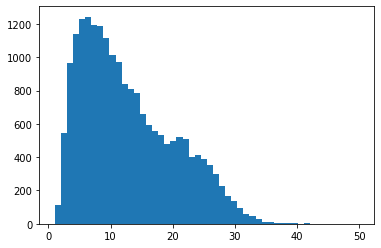

In [ ]:
#distribution of number of tokens per document
counts = list()
for i in range(len(hateXplain['tokens_processed'])):
    counts.append(len(hateXplain['tokens_processed'][i]))
    
plt.hist(counts, 50); # visualize distribution with histogram

## 2.2.3 Analysis of rationales <a id="rationales"></a>

In [ ]:
# count number of posts with rationales and confirm that they are all hateful ones

rat = []
for i in range(hateXplain.shape[0]):
    if len(hateXplain['rationales'][i]) > 1:
        rat.append(hateXplain['label'][i])

Counter(rat)

Counter({1: 11415})

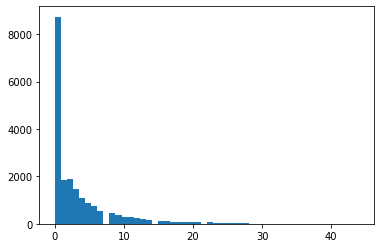

In [ ]:
#distribution of number of tokens per document
counts = list()
for i in range(len(hateXplain['rationales_comb'])): #include lengths of all unlabeled documents
    counts.append(sum(hateXplain['rationales_comb'][i]))
    
plt.hist(counts, 50); # visualize distribution with histogram

## 2.2.4 Most frequent words in text corpus <a id="frequent"></a>

In [ ]:
# retrieve all preprocessed words from corpus
all_words = list(itertools.chain.from_iterable(hateXplain['tokens_processed']))

n = 10 # number of most frequent words in corpus to return

Counter(all_words).most_common(n)

## 2.2.5 Two-dimensional projection of text corpus: UMAP <a id="2d"></a>

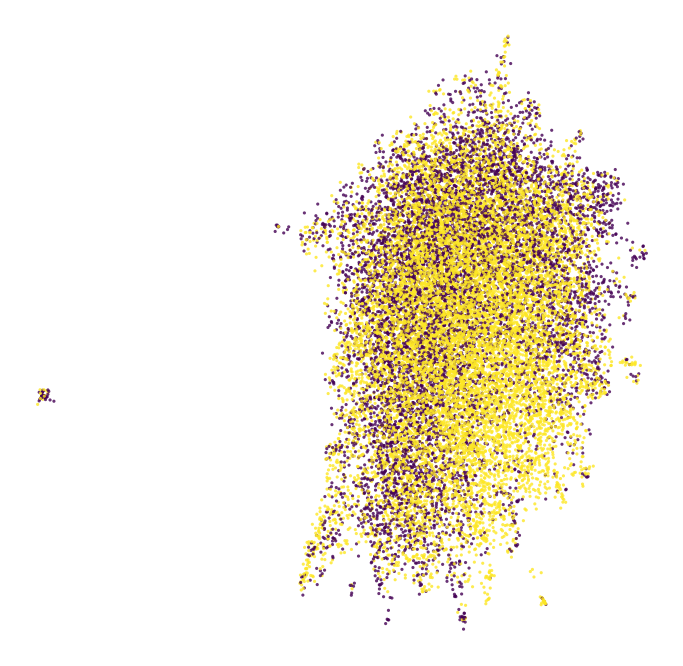

In [ ]:
embedding = umap.UMAP(n_neighbors=20, min_dist=0.6, metric='correlation').fit_transform(corp)

plt.figure(figsize=(12,12))
plt.scatter(embedding[:, 0], embedding[:, 1], 
            c=hateXplain['label'], 
            edgecolor='none', 
            alpha=0.80, 
            s=10)
plt.axis('off');

# 2.3 Export data <a id="export"></a>

In [ ]:
# export dataset as pickle
save_pickle(corp, '/content/drive/MyDrive/Seminar/data_corpus.pickle')
save_pickle(hateXplain['label'], '/content/drive/MyDrive/Seminar/labels.pickle')
save_pickle(hateXplain['rationales'], '/content/drive/MyDrive/Seminar/rationales.pickle')

/content/drive/MyDrive/Seminar/data_corpus.pickle successfully pickled.
/content/drive/MyDrive/Seminar/labels.pickle successfully pickled.
/content/drive/MyDrive/Seminar/rationales.pickle successfully pickled.
